# Implemention of the Behavior Pattern Method
nach 
Diamantini, C., Genga, L. & Potena, D. Behavioral process mining for unstructured processes. J Intell Inf Syst 47, 5–32 (2016). https://doi.org/10.1007/s10844-016-0394-7

In [1]:
import pm4py
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.obj import Event
from pm4py.objects.log.obj import Trace
from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.objects.petri_net.importer import importer as pnml_importer

import os
import json
from src.helper import HiddenPrints 

## Import XES File
from https://pm4py.fit.fraunhofer.de/documentation#item-impoort-xes

Event Log, und Trace: 
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.log.html?  highlight=objects%20log%20obj%20eventlog#pm4py.objects.log.obj.EventLog

EventLog[] => Trace  
EventLog[][] => Event of Trace

#### Ist eine Bereiningung des Event Logs nötigt auf => Aktivitäten 
Der event Log zeigt die Events nicht die ausgeführten Aktivitäten, wirkt sich das aus auf die Generierung des Petri Net und Alignemt, weil die Events verwendet werden nicht die Aktivitäten.

In [2]:
path = "datasets/02_TestCompletedFFF_onlyTaskItems_simpleFilter.xes"
# path = "datasets/01_TestCompletedFFF_IDtoString_removeTransitionClassifier.xes"
log = xes_importer.apply(path)
log = pm4py.filter_case_size(log, 0, 300)

parsing log, completed traces :: 100%|██████████| 81/81 [00:01<00:00, 77.01it/s]


In [3]:
# Event dict Eigenschaften 
print(log[0][0])

{'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2019, 11, 20, 13, 57, 10, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'cdb_process_id': 'P00062587', 'concept:instance': 326309, 'concept:name': 'Product Modification Responsible is correctly assigned?', 'description': "The task has been completed.  It's OK", 'division': 'UNDEFINED', 'msgtype': 'DONE', 'org:resource': '1079b397-2699-11ec-8124-0050568b0d8f', 'task_id': 'T00010248'}


BoxPLot, um Size Verteilung zu sehen und Ausreißer zu identifizieren.
Ziel dadurch das Modell zu vereinfachen und Zeit in dr Berechnung der Alignment zu sparen: 

Der BoxPLot zeigt anhand der Trace Sizes 2 Ausreißer an: >800 und >300


121.92405063291139


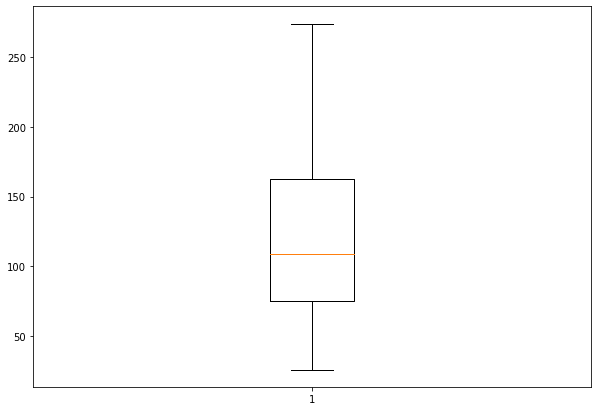

In [4]:
import matplotlib.pyplot as plt

# Creating dataset
data = list()
summe= 0
for trace in log:
    trace_len = len(trace)
    data.append(trace_len)
    summe += trace_len

print(summe/len(data))

fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

### Adding Orga Unit und lifecycleTransition 
Ich verwende Division, weil Ressource ein zu komplexes Modell liefern würde und die Ressourcen verschlüsselt. Daher schwierig Aussagekraft abzuleiten. Aussage kräftiger, wenn Divisionen angeschaut. 

Probleme mit dem Discovery Modell mit dem zusammengesetzten Classifier aus der Division und Name.

Integration des lifecycle dauert die Generieung eins Petrinetzes sehr lange.

In [5]:
customClassifierDivision = "customClassifierDivision"
customClassifierRessource = "customClassifierRessource"

from src.log_classifier_helper import addDivisionClassifier


## Get Real Welt Modell as Petri Net 
with Inductive Miner Infrequent for Casual Relation  
from https://pm4py.fit.fraunhofer.de/documentation#item-3-2  
Parameters: https://pm4py.fit.fraunhofer.de/static/assets/api/2.1.0/pm4py.algo.discovery.inductive.html?highlight=parameters%20activity_key#pm4py.algo.discovery.inductive.parameters.Parameters

The noise threshold (between 0.0 and 1.0) to be used. Default: 0.2

Dauer ca. 2min

Division funktioniert

Division Lifecycle => bricht ab ohne fehler

Ressource funktioinert nicht! => Algorithmus bricht ab ohne Fehler-

In [6]:
##### Import Section

petri_net_division_name_Path = os.path.join("output/petri_net_division_name.pnml")
petri_net_name_Path = os.path.join("output/petri_net_name.pnml")

path = petri_net_name_Path

std_classifier = "concept:name"
customClassifierDivision = "customClassifierDivision"
customClassifierRessource = "customClassifierRessource"
classifier=customClassifierDivision
# addDivisionClassifier(log, customClassifierDivision)

net, initial_marking, final_marking = pnml_importer.apply(path)



## Auswertung der Kanten 
Aus dem Event Log wurde mithilfe des Inductive Miner Infrequnent (vgl. Leemans at al 2014) ein Real welt Modell erstellt. less frequent behavior, loops ect. finden (vgl. Dimanatini)  
Output Petrie Netz. Ergebnis dient zur Grundlage für für die Casual Rel Eigenschaft und im folgende für das Instance ordering, d.h. Einfluss die Qualitäten der Kanten Bindungen der Instance Graphen.


Zwei Ansätze ausprobiert:  
Event Name Only - nicht nac methode, würde in nachträgliches einfügen der ressource oder Division benötigen.
Custom Classifier Division - mit Diviison nach methode
Custom Classifiier Ressource - Algorithmus hat sich nicht beendet, unbekannte Ursache

In [7]:
print('Transitionen: ', len(net.transitions))
print('Silent Transitionen: ', len({trans for trans in net.transitions if trans.label == None}))
print('Silent Transitionen: ', len({trans for trans in net.transitions if trans.label != None}))

Transitionen:  332
Silent Transitionen:  226
Silent Transitionen:  106


Zur Auswertung der petri Netzes Statistik Auswertung des Instance Ordering.
Meine Implementation des ein Instance Ordering Tupel existiert, wenn zwei Transitionen über eine Stelle Verbunden sind.
Aussage über Qualität möglich.

Wie hoch ist der Anteil an silent Transition; Transitionen,die keine Entsprechung im trace haben
Häufigkeit Silent Transitionen, Silent Trans und Aktivitäten und zwischen Aktivitäten:

Mit Division Classifier:  
Transitionen:  560  
Silent Transitionen:  406  
Silent Transitionen:  154  

Ohne Custom Classifier:  
Transitionen:  332  
Silent Transitionen:  226  
Silent Transitionen:  106  

Kritik an Statistik: 
einige Silent Transitionen stehen für tauJoin und Tausplit => Verhaltensrelevant, herausnehmen? weiß zu wenig




In [8]:
anteilSilent = round(406 / 560 *100, 2)
anteilActivities = round(154 / 560  *100, 2)

print(anteilSilent, anteilActivities)

anteilSilent = round(226 / 332 *100, 2)
anteilActivities = round(106 / 332  *100, 2)

print(anteilSilent, anteilActivities)

72.5 27.5
68.07 31.93


Wir stellen fest, dass der Anteil der Silent Transitionen überwiegt im Vergleich zu den mit Aktivitäten.


## From Petri Netz zu Instance Ordering  

### Casual Relation:

Zwei events i, j haben eine Causal Relation, wenn i erst abgeschlossen werden muss, damit j ausgeführt werden kann.  
Das Petri Netz ist Modell und die CR Relation, bzw. die Grundlage davon. 

Es sind in der relation keine Silent Transitionen aus dem 
Petri Netz enthalten!

### Instance Ordering: 

i, j und k sind Events; i<k<j  
Es besteht eine CR Relation zwischen i und j;  
und  
(Es darf keine CR Relation zwischen i und k:  
Oder  
Es darf keine CR Relation zwischen k und j geben;)  

Bezug zum Petri Netz, welches als Grundlage für die CR Relation verwendet wird:  
Ein Event ist im Petri Netz eine Transition; der Aktivitäten Name kann über Label aufgerufen werden.
Im Ordering sid keine silent Transitionen aus dem Petri Net enthalten

Siehe hierzu auch  
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.petri_net.html?highlight=petrinet#pm4py.objects.petri_net.obj.PetriNet  
https://pm4py.fit.fraunhofer.de/documentation#item-4-2

In [9]:
from src.casual_releation import calculateCR

In [15]:
cr = calculateCR(net)
print('# Casual Relations', len(cr))

""" 
Depth ist der Wert wie viele Aktivitäten zwischen dem Casual Predecessor und dem Casual Successor
Starts at -1 (Überspringt sich selbst als predecessor)), -1 is an self-loop, 0 fullFills an instanceOrdering characteristic    
"""
instanceOrdering = {(source,target) for (source,target,depth) in cr if(depth < 1)}
print('# Direkte Nachfolger mit der Instance Ordering Eigenschaft', len(instanceOrdering))
print('# Nachfolger Tiefe 1', len({(source,target) for (source,target,depth) in cr if(depth == 1)}))
print('# Nachfolger Tiefe 2', len({(source,target) for (source,target,depth) in cr if(depth == 2)}))
print('# Nachfolger Tiefe 3', len({(source,target) for (source,target,depth) in cr if(depth == 3)}))
print('Min Tiefe: ', min(cr,key=lambda cr: cr[2])[2]) # -1 => self loop exists
print('Maximum Tiefe: ', max(cr,key=lambda cr: cr[2])[2])

100%|██████████| 332/332 [00:00<00:00, 7592.25it/s]

# Casual Relations 6756
# Direkte Nachfolger mit der Instance Ordering Eigenschaft 2202
# Nachfolger Tiefe 1 1260
# Nachfolger Tiefe 2 908
# Nachfolger Tiefe 3 747
Min Tiefe:  -1
Maximum Tiefe:  12


### Problem My Instance ordering Implementation
![alt text](assets/my_implementation_instance_ordering_problem1.png "Title")
![alt text](assets/my_implementation_instance_ordering_problem2.png "Title")

## Instance Graphen

Werden aus dem Instance Ordering, welches  aus der vorangegangen Methode erhalten haben.
Es wird nun nach den Vorgaben aus den Wissenschaftlichen Beitrag ein Instanz Graph erstellt.  
Ein Instance Graph wird ein Tupel aus Knoten, edges und einen Dictionary sein, welches ein Mapping zwischen dem den Knoten und dem entsprechenden Log Event darstellt.

Referenzen zum Event Log
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.log.html?highlight=eventlog#pm4py.objects.log.obj.EventLog



In [11]:
## instance_graph.py
from src.instance_graph import genInstanceGraph
from src.instance_graph import buildingInstanceGraphsFromLog

### Generiere alle Instanz Graphen ohne Reparatur

In [12]:
instanceGraphs = list()
cr = calculateCR(net)
for instance in log:
    nodes, edges, nodeEventDict = genInstanceGraph(instance, cr)
    instanceGraphs.append((nodes, edges, nodeEventDict))


100%|██████████| 332/332 [00:00<00:00, 5779.70it/s]


## Repair irreguläre Instanz Graphen 

### PM4Py Alignment: Kosten der Abweichen benutzen zum aufspüren irregulärer Traces
https://pm4py.fit.fraunhofer.de/documentation#item-5-2

Spüren mithilfe der aligmentn Kosten auf ob deletet oder inserted. Nach Definiion.

Docs: https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.algo.conformance.alignments.petri_net.html#pm4py.algo.conformance.alignments.petri_net.algorithm.apply_log

Alignment zu berechnen dauert lange in Jupyter: bis zu 30h

Source: S. 105 & 106 Diamantini, C., Genga, L., Potena, D., and van der Aalst, W. 2016. “Building instance graphs for highly variable processes,” Expert Systems with Applications (59), pp. 101-118 (doi: 10.1016/j.eswa.2016.04.021).


### Alignment
* Sync move: the classification of the event corresponds to the transition label; in this case, both the trace and the model advance in the same way during the replay.
+ Move on log: for couples where the second element is », it corresponds to a replay move in the trace that is not mimicked in the model. This kind of move is unfit and signal a deviation between the trace and the model.
* Move on model: for couples where the first element is », it corresponds to a replay move in the model that is not mimicked in the trace. For moves on model, we can have the following distinction:
  * Moves on model involving hidden transitions: in this case, even if it is not a sync move, the move is fit.
  * Moves on model not involving hidden transitions: in this case, the move is unfit and signals a deviation between the trace and the model.
  
from https://pm4py.fit.fraunhofer.de/documentation#item-5-2  
Stimmt mit der Literatur überein:

### Irregulare Traces / Move in the Model
Irregular Traces are Move in the Models. In such a way it is described in  
S. 106 Diamantini, C., Genga, L., Potena, D., and van der Aalst, W. 2016. “Building instance graphs for highly variable processes,” Expert Systems with Applications (59), pp. 101-118 (doi: 10.1016/j.eswa.2016.04.021).

log move = inserted; model move = deleted vgl. s. 106 in Diamantini et al 2016 

In [13]:
# conformance_with_alignment
from src.conformance_with_alignment import loadAlignment
from src.conformance_with_alignment import sortLogAndModelMove
from src.conformance_with_alignment import sortLogAndModelMoveWithSilent

Alignment Berechnung in kleine Teile aufgespalten und in Json gesichert:  
JSON from here https://www.geeksforgeeks.org/read-write-and-parse-json-using-python/?ref=lbp

In [14]:
alignmentDict = loadAlignment(log)
traceVaraintDict = {trace.attributes['variant']:trace for trace in log} 
fitness = list()
anteileIR = list()

for key, item in alignmentDict.items():
    alignment = item['alignment']
    lenAlign = len(alignment)
    lenTrace = len(traceVaraintDict[key])
    modelMoves, logMoves = sortLogAndModelMove(alignment)
    modelmSil, LogmSil = sortLogAndModelMoveWithSilent(alignment)
    lenModelMoves = len(modelMoves)
    lenlogMoves = len(logMoves)
    fitness.append(item['fitness'])
    anteilAlign= (lenModelMoves +lenlogMoves) / lenAlign
    anteilTrace = (lenModelMoves +lenlogMoves) / lenTrace
    anteileIR.append(anteilTrace)
    print(key + ' Trace | Alignments: ' + str(lenTrace) + '|' + str(lenAlign))
    print('irregular Traces (ohne Silent): ' + str(lenModelMoves+lenlogMoves ))
    print('Fitness: ' + str(item['fitness']))
    print('irregular Traces Anteil From Trace: ' + str(anteilTrace))
    print('irregular Traces Anteil From Alignemt: ' + str(anteilAlign))
    print('ModelMoves:' + str(lenModelMoves))
    print('ModelMovesSil:' + str(len(modelmSil)-lenModelMoves))
    print('LogMoves:' + str(lenlogMoves))
    print('LogMovesSil:' + str(len(LogmSil)-lenlogMoves))
    print('______________________')



Variant 14 Trace | Alignments: 63|162
irregular Traces (ohne Silent): 0
Fitness: 1.0
irregular Traces Anteil From Trace: 0.0
irregular Traces Anteil From Alignemt: 0.0
ModelMoves:0
ModelMovesSil:1
LogMoves:0
LogMovesSil:0
______________________
Variant 18 Trace | Alignments: 49|147
irregular Traces (ohne Silent): 2
Fitness: 0.9444444444444444
irregular Traces Anteil From Trace: 0.04081632653061224
irregular Traces Anteil From Alignemt: 0.013605442176870748
ModelMoves:0
ModelMovesSil:1
LogMoves:2
LogMovesSil:0
______________________
Variant 30 Trace | Alignments: 70|166
irregular Traces (ohne Silent): 2
Fitness: 0.9466666666666667
irregular Traces Anteil From Trace: 0.02857142857142857
irregular Traces Anteil From Alignemt: 0.012048192771084338
ModelMoves:0
ModelMovesSil:1
LogMoves:2
LogMovesSil:0
______________________
Variant 39 Trace | Alignments: 26|91
irregular Traces (ohne Silent): 2
Fitness: 0.935483870967742
irregular Traces Anteil From Trace: 0.07692307692307693
irregular Trace

Note that although edges in Ea are not allowed by the model, using these edges to connect the occurred insertion we limit significantly the overgeneralization with respect the original iIG IGins .


## Reparierte Instance Graphen bauen

In [15]:
# net, initial_marking, final_marking = pnml_importer.apply(os.path.join(importPath))
variantAlignmentDict = loadAlignment(log)
with HiddenPrints():
    instanceGraphsDict = buildingInstanceGraphsFromLog(log,net,variantAlignmentDict)


  0%|          | 0/79 [00:00<?, ?it/s]


AssertionError: 

### Eigenschaften die der die Graphen erfüllen müssen, für Forschunsgfrage



## Subgraph Mining und Behavior Pattern

In [ ]:
from src.subgraph_mining import createSubdueInputFile
from src.behavior_pattern import calcBehaviorPattern
# subrpocesss to call bash commands, from here: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script
import subprocess

In [ ]:
# Apply SubGraph to instanceGraphes

outputFilePath = 'output/output-subdue.g'
inputFilePath = '/home/adrian/Schreibtisch/behavior-pattern-miner/output/subdueGraphs.g'

createSubdueInputFile(instanceGraphsDict, outputFilePath)

output = subprocess.check_output(['/home/adrian/Schreibtisch/behavior-pattern-miner/subdue-5.2.2/bin/subdue','-eval','1', '-iterations', '0', '-out', outputFilePath, inputFilePath])
outputString = str(output)

In [ ]:
import subprocess
utput = subprocess.check_output(['/home/adrian/Schreibtisch/behavior-pattern-miner/subdue-5.2.2/bin/mdl_custom', '/home/adrian/Schreibtisch/behavior-pattern-miner/' + 'output/input-g2-mdl.g', '/home/adrian/Schreibtisch/behavior-pattern-miner/' + 'output/input-g1-mdl' + '.g'])

In [ ]:
grenze = 2

behaviorPattern = calcBehaviorPattern(instanceGraphsDict, grenze)


In [ ]:
print(behaviorPattern)

[]


/home/adrian/Schreibtisch/subdue-5.2.2/bin/subdue -eval 1 -iterations 0 -overlap -out output-subdue /home/adrian/Schreibtisch/behavior-pattern-miner/output/subdueGraphs.g

Call from bin
./subdue -eval 1 -iterations 0 -overlap /home/adrian/Schreibtisch/behavior-pattern-miner/output/subdueGraphs.g

-out output/output-subdue

## Combination of all functions do compute BP

In [ ]:
def mineBehBehavioralPattern(eventLog: EventLog, net: PetriNet, alignment: dict, classifier="concept:name"):
    instanceGraphDict = buildingInstanceGraphsFromLog(eventLog, net, alignment, classifier)
    print('Generated Instnce Graphes')
    threshold = 3
    return calcBehaviorPattern(instanceGraphDict, threshold)


## Visualisierung Instance Graphen

Bibliothek NetworkX Data Struktur  
https://networkx.org/documentation/stable/tutorial.html  
https://networkx.org/documentation/stable/reference/classes/digraph.html  
https://www.youtube.com/watch?v=xREnpVUbkFI  
Hierachie Graph (Baum): https://stackoverflow.com/questions/11479624/is-there-a-way-to-guarantee-hierarchical-output-from-  
Flow Chart, with Lib:
https://stackoverflow.com/questions/39801880/how-to-use-the-pos-argument-in-networkx-to-create-a-flowchart-style-graph/39863493  
https://github.com/paulbrodersen/netgraph  
Network X Flow Chart Template:   
https://stackoverflow.com/questions/22920433/python-draw-flowchart-illustration-graphs

In [ ]:
from src.draw_instance_graph import drawInstanceGraph
from src.draw_instance_graph import transformToNetworkxGraph

In [ ]:
""" for variant, iGraph in instanceGraphsDict.items():
    plot  = drawInstanceGraph(iGraph)
    plot.savefig('output/graphs/'+variant+'.png')
    plot.close() """